In [25]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


# Robotique : Gym
Dans cette partie nous allons utiliser gym, une librairie permettant de manipuler des environnements physiques facilement en vue d'expérimenter des algorithmes permettant d'apprendre efficacement des politiques.

In [7]:
env = gym.make('CartPole-v1')
observation = env.reset()
total_reward = 0
for t in range(100):
    env.render()
    action = np.random.rand(1,)
    if action > 0:
        action = 1
    else:
        action = 0
    observation, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        print("Episode finished after %d timesteps" % (t + 1))
        break

Episode finished after 10 timesteps


On voit bien qu'avec une politique aléatoire le cart tiens seulement 9 timesteps a l'écran.
Dans ce qui suit nous allons entrainer un controller afin de controller le carte et de le faire rester le plus longtemps possible a l'écran.
La structure du controller serra évidente : 
- Etant donné que l'observation se compose de 4 données (position, velocity, angle, velocity du cable) le réseau de neurones prendra ces 4 paramètres en entrée
- La sortie serra tanh et ferra dépendre l'action a prendre
- La fonction d'évaluation serra simplement le reward total cumulé.

In [3]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gen_simplemlp(n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5):
    n_neurons = [n_neurons_per_hidden]*n_hidden_layers if np.isscalar(n_neurons_per_hidden) else n_neurons_per_hidden
    i = Input(shape=(n_in,))
    x = i
    for n in n_neurons:
        x = Dense(n, activation='sigmoid')(x)
    o = Dense(n_out, activation='tanh')(x)
    m = Model(inputs=i, outputs=o)
    return m
    

class SimpleNeuralControllerNumpy():
    def __init__(self, n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5, params=None):
        self.dim_in = n_in
        self.dim_out = n_out
        # if params is provided, we look for the number of hidden layers and neuron per layer into that parameter (a dicttionary)
        if (not params==None):
            if ("n_hidden_layers" in params.keys()):
                n_hidden_layers=params["n_hidden_layers"]
            if ("n_neurons_per_hidden" in params.keys()):
                n_neurons_per_hidden=params["n_neurons_per_hidden"]
        self.n_per_hidden = n_neurons_per_hidden
        self.n_hidden_layers = n_hidden_layers
        self.weights = None 
        self.n_weights = None
        self.init_random_params()
        self.out = np.zeros(n_out)
        #print("Creating a simple mlp with %d inputs, %d outputs, %d hidden layers and %d neurons per layer"%(n_in, n_out,n_hidden_layers, n_neurons_per_hidden))

    
    def init_random_params(self):
        if(self.n_hidden_layers > 0):
            self.weights = [np.random.random((self.dim_in,self.n_per_hidden))] # In -> first hidden
            self.bias = [np.random.random(self.n_per_hidden)] # In -> first hidden
            for i in range(self.n_hidden_layers-1): # Hidden -> hidden
                self.weights.append(np.random.random((self.n_per_hidden,self.n_per_hidden)))
                self.bias.append(np.random.random(self.n_per_hidden))
            self.weights.append(np.random.random((self.n_per_hidden,self.dim_out))) # -> last hidden -> out
            self.bias.append(np.random.random(self.dim_out))
        else:
            self.weights = [np.random.random((self.dim_in,self.dim_out))] # Single-layer perceptron
            self.bias = [np.random.random(self.dim_out)]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def get_parameters(self):
        """
        Returns all network parameters as a single array
        """
        flat_weights = np.hstack([arr.flatten() for arr in (self.weights+self.bias)])
        return flat_weights

    def set_parameters(self, flat_parameters):
        """
        Set all network parameters from a single array
        """
        i = 0 # index
        to_set = []
        self.weights = list()
        self.bias = list()
        if(self.n_hidden_layers > 0):
            # In -> first hidden
            w0 = np.array(flat_parameters[i:(i+self.dim_in*self.n_per_hidden)])
            self.weights.append(w0.reshape(self.dim_in,self.n_per_hidden))
            i += self.dim_in*self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                w = np.array(flat_parameters[i:(i+self.n_per_hidden*self.n_per_hidden)])
                self.weights.append(w.reshape((self.n_per_hidden,self.n_per_hidden)))
                i += self.n_per_hidden*self.n_per_hidden
            # -> last hidden -> out
            wN = np.array(flat_parameters[i:(i+self.n_per_hidden*self.dim_out)])
            self.weights.append(wN.reshape((self.n_per_hidden,self.dim_out)))
            i += self.n_per_hidden*self.dim_out
            # Samefor bias now
            # In -> first hidden
            b0 = np.array(flat_parameters[i:(i+self.n_per_hidden)])
            self.bias.append(b0)
            i += self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                b = np.array(flat_parameters[i:(i+self.n_per_hidden)])
                self.bias.append(b)
                i += self.n_per_hidden
            # -> last hidden -> out
            bN = np.array(flat_parameters[i:(i+self.dim_out)])
            self.bias.append(bN)
            i += self.dim_out
        else:
            n_w = self.dim_in*self.dim_out
            w = np.array(flat_parameters[:n_w])
            self.weights = [w.reshape((self.dim_in,self.dim_out))]
            self.bias = [np.array(flat_parameters[n_w:])]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])
    
    def predict(self,x):
        """
        Propagage
        """
        if(self.n_hidden_layers > 0):
            #Input
            a = np.matmul(x,self.weights[0]) + self.bias[0]
            y = sigmoid(a)
            # hidden -> hidden
            for i in range(1,self.n_hidden_layers-1):
                a = np.matmul(y, self.weights[i]) + self.bias[i]
                y = sigmoid(a)
            # Out
            a = np.matmul(y, self.weights[-1]) + self.bias[-1]
            out = tanh(a)
            return out
        else: # Simple monolayer perceptron
            return tanh(np.matmul(x,self.weights[0]) + self.bias[0])

    def __call__(self,x):
        """Calling the controller calls predict"""
        return self.predict(x)


nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)


In [4]:
def eval_nn(genotype, render=False):
    total_reward=0
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    #Comment modifier le réseau de neurones selon le genotype ?
    #Votre code ICI
    observation = env.reset()
    for t in range(1000):
        if render:
            env.render()
        #Cette ligne permet d'utiliser le NN pour prédire la prochaine action
        action=nn.predict(observation)
        if action>0:
            action=1
        else:
            action=0
        observation, reward, done, info = env.step(action)
        total_reward+=reward
        if done:
            print("Episode finished after %d timesteps"%(t+1))
            break
    return -total_reward

In [5]:
import cma.purecma as purecma
nn = SimpleNeuralControllerNumpy(4, 1, 2, 5)
nn.init_random_params()
w = nn.get_parameters()

#Considérant ceci comme le point de départ d'un algorithme CMA-ES utilisez la librairie CMA pour fit
#le réseau de neurone afin qu'il maximise le "total reward"


(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 61 (seed=280918, Mon Apr  6 17:01:01 2020)
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 9 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 8 timesteps
Episode finished after 10 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.000000000000000e+01 1.0e+00 4.73e-01  5e-01  5e-01 0:00.1
Episode finished after 9 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 11 timesteps
Episode finished after 10 timesteps
Episode finished

Episode finished after 26 timesteps
Episode finished after 50 timesteps
Episode finished after 50 timesteps
Episode finished after 18 timesteps
Episode finished after 42 timesteps
Episode finished after 17 timesteps
Episode finished after 10 timesteps
Episode finished after 45 timesteps
Episode finished after 19 timesteps
Episode finished after 11 timesteps
Episode finished after 11 timesteps
Episode finished after 13 timesteps
Episode finished after 10 timesteps
Episode finished after 10 timesteps
Episode finished after 22 timesteps
Episode finished after 11 timesteps
Episode finished after 9 timesteps
Episode finished after 18 timesteps
Episode finished after 10 timesteps
Episode finished after 12 timesteps
Episode finished after 8 timesteps
Episode finished after 8 timesteps
Episode finished after 15 timesteps
Episode finished after 9 timesteps
Episode finished after 25 timesteps
Episode finished after 30 timesteps
Episode finished after 18 timesteps
Episode finished after 33 timest

Episode finished after 59 timesteps
Episode finished after 29 timesteps
Episode finished after 17 timesteps
Episode finished after 32 timesteps
Episode finished after 45 timesteps
Episode finished after 32 timesteps
Episode finished after 69 timesteps
Episode finished after 21 timesteps
Episode finished after 35 timesteps
Episode finished after 34 timesteps
Episode finished after 34 timesteps
Episode finished after 26 timesteps
Episode finished after 72 timesteps
Episode finished after 34 timesteps
Episode finished after 27 timesteps
Episode finished after 52 timesteps
Episode finished after 33 timesteps
Episode finished after 18 timesteps
Episode finished after 45 timesteps
Episode finished after 12 timesteps
Episode finished after 41 timesteps
Episode finished after 29 timesteps
Episode finished after 23 timesteps
Episode finished after 17 timesteps
Episode finished after 33 timesteps
Episode finished after 39 timesteps
Episode finished after 74 timesteps
Episode finished after 55 ti

Episode finished after 44 timesteps
Episode finished after 49 timesteps
Episode finished after 21 timesteps
Episode finished after 70 timesteps
Episode finished after 59 timesteps
Episode finished after 23 timesteps
Episode finished after 23 timesteps
Episode finished after 33 timesteps
Episode finished after 22 timesteps
Episode finished after 18 timesteps
Episode finished after 53 timesteps
Episode finished after 34 timesteps
Episode finished after 27 timesteps
Episode finished after 46 timesteps
Episode finished after 59 timesteps
Episode finished after 41 timesteps
Episode finished after 29 timesteps
Episode finished after 22 timesteps
Episode finished after 34 timesteps
Episode finished after 14 timesteps
Episode finished after 31 timesteps
Episode finished after 63 timesteps
Episode finished after 53 timesteps
Episode finished after 89 timesteps
Episode finished after 47 timesteps
Episode finished after 48 timesteps
Episode finished after 52 timesteps
Episode finished after 38 ti

Episode finished after 44 timesteps
Episode finished after 58 timesteps
Episode finished after 89 timesteps
Episode finished after 24 timesteps
Episode finished after 27 timesteps
Episode finished after 29 timesteps
Episode finished after 25 timesteps
Episode finished after 19 timesteps
Episode finished after 40 timesteps
Episode finished after 27 timesteps
Episode finished after 40 timesteps
Episode finished after 24 timesteps
Episode finished after 32 timesteps
Episode finished after 27 timesteps
Episode finished after 30 timesteps
Episode finished after 46 timesteps
Episode finished after 22 timesteps
Episode finished after 80 timesteps
Episode finished after 40 timesteps
Episode finished after 39 timesteps
Episode finished after 31 timesteps
Episode finished after 45 timesteps
Episode finished after 57 timesteps
Episode finished after 21 timesteps
Episode finished after 31 timesteps
Episode finished after 27 timesteps
Episode finished after 36 timesteps
Episode finished after 73 ti

Episode finished after 54 timesteps
Episode finished after 53 timesteps
Episode finished after 37 timesteps
Episode finished after 44 timesteps
Episode finished after 67 timesteps
Episode finished after 18 timesteps
Episode finished after 68 timesteps
Episode finished after 57 timesteps
Episode finished after 91 timesteps
Episode finished after 27 timesteps
Episode finished after 32 timesteps
Episode finished after 29 timesteps
Episode finished after 30 timesteps
Episode finished after 61 timesteps
Episode finished after 79 timesteps
Episode finished after 37 timesteps
Episode finished after 28 timesteps
Episode finished after 53 timesteps
Episode finished after 29 timesteps
Episode finished after 47 timesteps
Episode finished after 30 timesteps
Episode finished after 39 timesteps
Episode finished after 42 timesteps
Episode finished after 104 timesteps
Episode finished after 29 timesteps
Episode finished after 31 timesteps
Episode finished after 45 timesteps
Episode finished after 45 t

Episode finished after 51 timesteps
Episode finished after 33 timesteps
Episode finished after 53 timesteps
Episode finished after 28 timesteps
Episode finished after 49 timesteps
Episode finished after 36 timesteps
Episode finished after 24 timesteps
Episode finished after 60 timesteps
Episode finished after 48 timesteps
Episode finished after 25 timesteps
Episode finished after 63 timesteps
Episode finished after 24 timesteps
Episode finished after 39 timesteps
Episode finished after 47 timesteps
Episode finished after 25 timesteps
Episode finished after 45 timesteps
Episode finished after 45 timesteps
Episode finished after 40 timesteps
Episode finished after 43 timesteps
Episode finished after 52 timesteps
Episode finished after 44 timesteps
Episode finished after 35 timesteps
Episode finished after 40 timesteps
Episode finished after 28 timesteps
Episode finished after 76 timesteps
Episode finished after 40 timesteps
Episode finished after 32 timesteps
Episode finished after 30 ti

Episode finished after 71 timesteps
Episode finished after 39 timesteps
Episode finished after 51 timesteps
Episode finished after 61 timesteps
Episode finished after 50 timesteps
Episode finished after 60 timesteps
Episode finished after 34 timesteps
Episode finished after 33 timesteps
Episode finished after 38 timesteps
Episode finished after 37 timesteps
Episode finished after 26 timesteps
Episode finished after 47 timesteps
Episode finished after 94 timesteps
Episode finished after 47 timesteps
Episode finished after 49 timesteps
Episode finished after 39 timesteps
Episode finished after 48 timesteps
Episode finished after 32 timesteps
Episode finished after 34 timesteps
Episode finished after 34 timesteps
Episode finished after 32 timesteps
Episode finished after 51 timesteps
Episode finished after 54 timesteps
Episode finished after 53 timesteps
Episode finished after 30 timesteps
Episode finished after 27 timesteps
Episode finished after 44 timesteps
Episode finished after 41 ti

Episode finished after 72 timesteps
Episode finished after 30 timesteps
Episode finished after 131 timesteps
Episode finished after 45 timesteps
Episode finished after 39 timesteps
Episode finished after 120 timesteps
Episode finished after 77 timesteps
Episode finished after 43 timesteps
Episode finished after 51 timesteps
Episode finished after 62 timesteps
Episode finished after 60 timesteps
Episode finished after 34 timesteps
Episode finished after 79 timesteps
Episode finished after 30 timesteps
Episode finished after 67 timesteps
Episode finished after 55 timesteps
Episode finished after 59 timesteps
Episode finished after 59 timesteps
Episode finished after 30 timesteps
Episode finished after 41 timesteps
Episode finished after 78 timesteps
Episode finished after 43 timesteps
Episode finished after 54 timesteps
Episode finished after 30 timesteps
Episode finished after 60 timesteps
Episode finished after 48 timesteps
Episode finished after 41 timesteps
Episode finished after 124

Episode finished after 45 timesteps
Episode finished after 88 timesteps
Episode finished after 118 timesteps
Episode finished after 99 timesteps
Episode finished after 58 timesteps
Episode finished after 54 timesteps
Episode finished after 32 timesteps
Episode finished after 39 timesteps
Episode finished after 131 timesteps
Episode finished after 48 timesteps
Episode finished after 104 timesteps
Episode finished after 35 timesteps
Episode finished after 47 timesteps
Episode finished after 51 timesteps
Episode finished after 47 timesteps
Episode finished after 43 timesteps
Episode finished after 50 timesteps
Episode finished after 52 timesteps
Episode finished after 35 timesteps
Episode finished after 68 timesteps
Episode finished after 61 timesteps
Episode finished after 164 timesteps
Episode finished after 65 timesteps
Episode finished after 101 timesteps
Episode finished after 43 timesteps
Episode finished after 43 timesteps
Episode finished after 84 timesteps
Episode finished after 

Episode finished after 109 timesteps
Episode finished after 334 timesteps
Episode finished after 225 timesteps
Episode finished after 114 timesteps
Episode finished after 22 timesteps
Episode finished after 97 timesteps
Episode finished after 92 timesteps
Episode finished after 141 timesteps
Episode finished after 123 timesteps
Episode finished after 459 timesteps
Episode finished after 125 timesteps
Episode finished after 123 timesteps
Episode finished after 49 timesteps
Episode finished after 115 timesteps
Episode finished after 232 timesteps
Episode finished after 61 timesteps
Episode finished after 241 timesteps
Episode finished after 42 timesteps
Episode finished after 115 timesteps
Episode finished after 100 timesteps
Episode finished after 224 timesteps
Episode finished after 44 timesteps
Episode finished after 142 timesteps
Episode finished after 75 timesteps
Episode finished after 33 timesteps
Episode finished after 216 timesteps
Episode finished after 87 timesteps
Episode fin

Episode finished after 500 timesteps
Episode finished after 288 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 478 timesteps
Episode finished after 500 timesteps
Episode finished after 68 timesteps
Episode finished after 500 timesteps
Episode finished after 203 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 33 timesteps
Episode finished after 66 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 334 timesteps
Episode finished after 78 timesteps
Episode finished after 282 timesteps
Episode finished after 157 timesteps
Episode finished after 500 timesteps
Episode finished after 486 timesteps
Episode finished after 464 timesteps
Episode finished after 169 timesteps
Episode finished after 85 timesteps
Episod

Episode finished after 500 timesteps
Episode finished after 217 timesteps
Episode finished after 163 timesteps
Episode finished after 12 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 109 timesteps
Episode finished after 155 timesteps
Episode finished after 500 timesteps
Episode finished after 361 timesteps
Episode finished after 307 timesteps
Episode finished after 395 timesteps
Episode finished after 500 timesteps
Episode finished after 404 timesteps
Episode finished after 500 timesteps
Episode finished after 317 timesteps
Episode finished after 44 timesteps
Episode finished after 50 timesteps
Episode finished after 419 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 216 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Epis

Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 359 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 24 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 469 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 218 timesteps
Episode finished after 18 timesteps
Episode finished after 500 timesteps
Episode finished after 319 timesteps
Episode finished after 500 timesteps
Episode finished after 304 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 155 timesteps
Episode finished after 214 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 142 timesteps
Episode finished after 500 timesteps
Epi

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=6.41e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=202)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 13 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 275 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Ep

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=6.28e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=205)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 274 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 16 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 335 timesteps
Episode finished after 500 timesteps
Episode finished after 204 timesteps
Episode finished after 229 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 172 timesteps
Episode finished after 500 timesteps
Episode finished after 368 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 201 timesteps
Episode finished after 399 timesteps
Episode finished after 298 timesteps
Episode finished after 241 timesteps
Episode finished after 195 timesteps
Episode finished after 500 timesteps
Ep

Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=6.03e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=219)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 19 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 14 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 347 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 58 timesteps
Episode finished after 500 timesteps
Episode finished after 391 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Epis

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=223)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 435 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
E

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.50e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=225)
  ')')



Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 145 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.52e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=226)
  ')')



Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 363 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 276 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.63e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=230)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 11 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 11 timesteps
Epi

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.55e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=235)
  ')')



Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 34 timesteps
Episode finished after 500 timesteps
Episode finished after 40 timesteps
Episode finished after 305 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 483 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 198 timesteps
Episode finished after 402 timesteps
Episode finished after 500 timesteps
Episode finished after 286 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Ep

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.55e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=241)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 10 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 26 timesteps
Episode finished after 33 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 228 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Epis

Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 28 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 29 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Epi

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.52e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=261)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 374 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 55 timesteps
Episode finished after 180 timesteps
Episode finished after 190 timesteps
Episode finished after 199 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 24 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Epi

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.81e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=272)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.79e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=273)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps


/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.79e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=274)
  ')')
/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.77e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=275)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 436 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
E

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.61e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=277)
  ')')


Episode finished after 283 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
E

/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.52e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=279)
  ')')


Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
Episode finished after 500 timesteps
  280   4480 -5.000000000000000e+02 2.3e+00 5.50e-01  5e-01  6e-01 0:25.7


/home/mohamed/.local/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-500.000000, sigma=5.50e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=280)
  ')')


# Programmation Génétique :

In [9]:
import math
import random

import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [10]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

In [ ]:



creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def f(x):
    d = x**4 - x**3 + x**2 + np.sin(2*x+3)
    return d

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - f(x))**2 for x in points)
    return math.fsum(sqerrors) / len(points),



toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 172, stats=mstats,halloffame=hof, verbose=True)


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	3.35149	0  	23.9499	0.472098	300   	3.38171	3.70667	0  	7  	2  	300   	1.56864
1  	164   	2.03691	1  	13.8356	0.472098	164   	1.26964	3.65   	1  	12 	1  	164   	1.79281
2  	156   	1.83694	2  	21.5477	0.472098	156   	1.70543	3.66667	2  	10 	1  	156   	1.609  
3  	168   	1.60178	3  	17.2706	0.1141  	168   	1.5733 	4.08   	3  	13 	1  	168   	1.80377
4  	161   	1.42339	4  	6.4865 	0.1141  	161   	1.11589	4.35667	4  	13 	1  	161   	1.84828
5  	163   	1.43848	5  	21.0582	0.1141  	163   	2.02871	5.09   	5  	13 	2  	163   	2.0286 
6  	169   	1.27241	6  	15.9389	0.0224941	169   	1.48261	5.7    	6  	15 	1  	169   	2.14087
7  	146   	1.11296	7  	14.805 	0.0224941	146   	1

86 	164   	0.056061 	86 	3.99193	0.00414425	164   	0.304295	62.22  	86 	124	1  	164   	13.7375
87 	174   	0.096893 	87 	3.18449	0.00414425	174   	0.359597	61.9333	87 	131	3  	174   	16.3598
88 	140   	0.097702 	88 	4.11751	0.00414425	140   	0.440199	62.9833	88 	96 	5  	140   	12.772 
89 	167   	0.0912514	89 	5.68102	0.00414425	167   	0.42359 	62.6133	89 	110	3  	167   	15.1762
90 	156   	0.0706253	90 	2.19394	0.00414425	156   	0.314329	62.4867	90 	96 	3  	156   	15.3862
91 	171   	0.0535077	91 	3.36051	0.00414425	171   	0.27356 	62.8333	91 	99 	3  	171   	17.0139
92 	181   	0.0528552	92 	3.36051	0.00414425	181   	0.245146	64.73  	92 	109	4  	181   	15.8383
93 	174   	0.11636  	93 	6.25488	0.00414247	174   	0.616924	66.8033	93 	90 	3  	174   	14.7318
94 	162   	0.0692735	94 	4.70022	0.00414247	162   	0.417292	69.19  	94 	96 	7  	162   	15.4348
95 	133   	0.0409545	95 	4.05256	0.00414247	133   	0.259052	72.69  	95 	96 	7  	133   	13.7456
96 	176   	0.0752642	96 	2.83024	0.00406403	176   

In [ ]:
nodes, edges, labels = gp.graph(hof[0])

sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

In [ ]:
import gym
import numpy as np
import cma
import math
import random
import matplotlib.pyplot as plt
import numpy
import operator
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from numpy import linalg as LA
#Trés optionnel
import networkx as nx
from IPython.display import Image, display


x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def adapt(X):
    return np.hstack((X,np.ones((X.shape[0],1))))  

def predictions(w,x):
    ypredict = np.dot(x,w.T)
    return ypredict

w = np.dot(np.linalg.pinv(adapt(x)),y)
print("Donc le modèle qu'on trouve est : ",w.T)

plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,adapt(x))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

Donc le modèle qu'on trouve est :  [[-1.24845336 -0.07087609  1.11353692]]


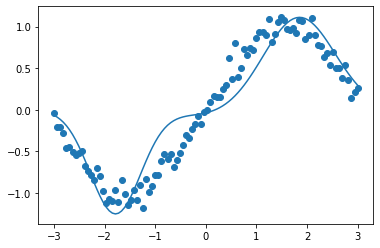

In [3]:
def radial_basis_func(X,center=0.5,widths=1):
    c = X[int(center*X.shape[0])]
    return np.exp(-np.divide(np.square(x - c), widths))

recepient = [(0.2,0.5),(0.5,1),(0.8,1)]

def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def display_recipients(X,reciepients):
    for r in reciepients:
        y = radial_basis_func(X,center = r[0],widths=r[1])
        plt.plot(X,y)
    plt.show()

w = np.dot(np.linalg.pinv(kernel(x,recepient).T.dot(kernel(x,recepient))),kernel(x,recepient).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,recepient))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

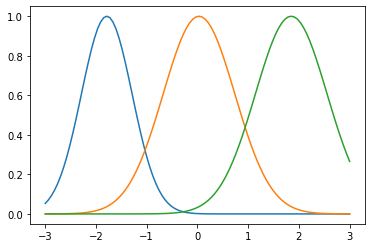

Donc le modèle qu'on trouve est :  [[-1.08645393  0.03556696  1.02007614]]


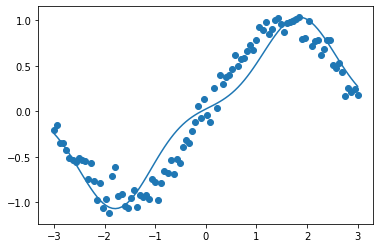

In [4]:
x = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)


#Expérimentez differentes configurations de kernel pour trouver la meilleure
configuration = [(0.2,1),(0.5,4),(0.8,1)]



display_recipients(x,recepient)

w = np.dot(np.linalg.pinv(kernel(x,configuration).T.dot(kernel(x,configuration))),kernel(x,configuration).T.dot(y))


print("Donc le modèle qu'on trouve est : ",w.T)
plt.scatter(x,y)
#Calcul des prédictions
ypred = predictions(w.T,kernel(x,configuration))
#Tracage du modèle : 
plt.plot(x,ypred)
plt.show()

In [4]:
def kernel(X,recipients):
    H = radial_basis_func(X,center = recipients[0][0],widths=recipients[0][1])
    for r in recipients[1:]:
        H = np.hstack((H,radial_basis_func(X,center = r[0],widths=r[1])))
    return H

def adding_kernel(X,rec):
    H = np.hstack((X,radial_basis_func(X,center = rec[0],widths=rec[1])))
    return H

def identity(x):
    return x

def recipien_generator():
    return tuple([np.random.rand(1)[0],np.random.uniform(1,10)])

pset2 = gp.PrimitiveSetTyped("KERN_MAIN", [np.ndarray],np.ndarray)
pset2.addPrimitive(adding_kernel, [np.ndarray, tuple], np.ndarray)
pset2.addPrimitive(identity, [tuple], tuple)

pset2.addEphemeralConstant("recipient2",recipien_generator , tuple)

pset2.renameArguments(ARG0='x')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset2, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset2)

In [6]:
from sklearn.metrics import mean_squared_error

X = np.linspace(-3,3,100).reshape((-1,1))
y = np.sin(x) + np.random.normal(0,0.1,x.shape)

def eval_kernel(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    K = func(X)
    try:
        w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
        ypred = predictions(w.T,K)
        fitness = mean_squared_error(y,ypred)
    except(np.linalg.LinAlgError):
        fitness = 1e20
    return fitness,



toolbox.register("evaluate", eval_kernel)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))




In [8]:
pop = toolbox.population(n=2)
hof = tools.HallOfFame(1)
    
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

pop,log= algorithms.eaMuPlusLambda(pop, toolbox, mu=20, lambda_=100, cxpb=0, mutpb=0.3, ngen=200, stats=mstats,halloffame=hof, verbose=True)


   	      	                                 fitness                                 
   	      	-------------------------------------------------------------------------
gen	nevals	avg      	gen	max     	min       	nevals	std      
0  	2     	0.0903954	0  	0.172068	0.00872243	2     	0.0816729
1  	31    	0.0169117	1  	0.172068	0.00869921	31    	0.0355955
2  	41    	0.00871764	2  	0.00874035	0.00868665	41    	1.38334e-05
3  	32    	0.00867268	3  	0.00872243	0.00842391	32    	8.01039e-05
4  	28    	0.00855042	4  	0.00872243	0.00806219	28    	0.000160707
5  	28    	0.00840698	5  	0.00868665	0.00806219	28    	0.000192491
6  	26    	0.00827035	6  	0.00868665	0.00806219	26    	0.000204519
7  	31    	0.00805751	7  	0.00806219	0.00803766	31    	8.6678e-06 
8  	28    	0.00805048	8  	0.00806219	0.00803766	28    	1.02531e-05
9  	30    	0.00804426	9  	0.00806219	0.00803766	30    	8.70442e-06
10 	29    	0.00803778	10 	0.00806219	0.00800742	29    	9.14754e-06
11 	33    	0.00802592	11 	0.00804142	0.00

121	31    	0.00761948	121	0.00761948	0.00761948	31    	8.67362e-19
122	26    	0.00761948	122	0.00761948	0.00761948	26    	8.67362e-19
123	24    	0.00761948	123	0.00761948	0.00761948	24    	8.67362e-19
124	34    	0.00761948	124	0.00761948	0.00761948	34    	8.67362e-19
125	32    	0.00761948	125	0.00761948	0.00761948	32    	8.67362e-19
126	28    	0.00761948	126	0.00761948	0.00761948	28    	8.67362e-19
127	29    	0.0076193 	127	0.00761948	0.00761767	29    	5.41738e-07
128	31    	0.00761903	128	0.00761948	0.00761767	31    	7.81932e-07
129	29    	0.00761902	129	0.00762664	0.00761767	29    	1.95651e-06
130	34    	0.00761794	130	0.00761948	0.00761767	34    	6.44798e-07
131	25    	0.00761767	131	0.00761767	0.00761767	25    	8.67362e-19
132	27    	0.00762157	132	0.0076957 	0.00761767	27    	1.70052e-05
133	44    	0.00762546	133	0.00775442	0.00761767	44    	2.96742e-05
134	32    	0.00761776	134	0.00762492	0.0076148 	32    	1.79333e-06
135	25    	0.00761736	135	0.00762492	0.00761418	25    	2.11486

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (6, 8), (5, 9), (9, 10), (10, 11), (4, 12), (12, 13), (13, 14), (3, 15), (15, 16), (2, 17), (17, 18), (18, 19), (1, 20), (20, 21), (0, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27)]
{0: 'adding_kernel', 1: 'adding_kernel', 2: 'adding_kernel', 3: 'adding_kernel', 4: 'adding_kernel', 5: 'adding_kernel', 6: 'adding_kernel', 7: 'x', 8: (0.1611642554011219, 1.1326922283738665), 9: 'identity', 10: 'identity', 11: (0.3488981461089866, 1.6706592948140604), 12: 'identity', 13: 'identity', 14: (0.006014821200239662, 6.606102059340743), 15: 'identity', 16: (0.06900194389782954, 3.129960207678879), 17: 'identity', 18: 'identity', 19: (0.21813917075261824, 2.1754185102222254), 20: 'identity', 21: (0.07723861929178144, 1.9614645598350853), 22: 'identity', 23: 'identity', 24: 'identity', 25: 'identity', 26: 'identity', 27: (0.873976047

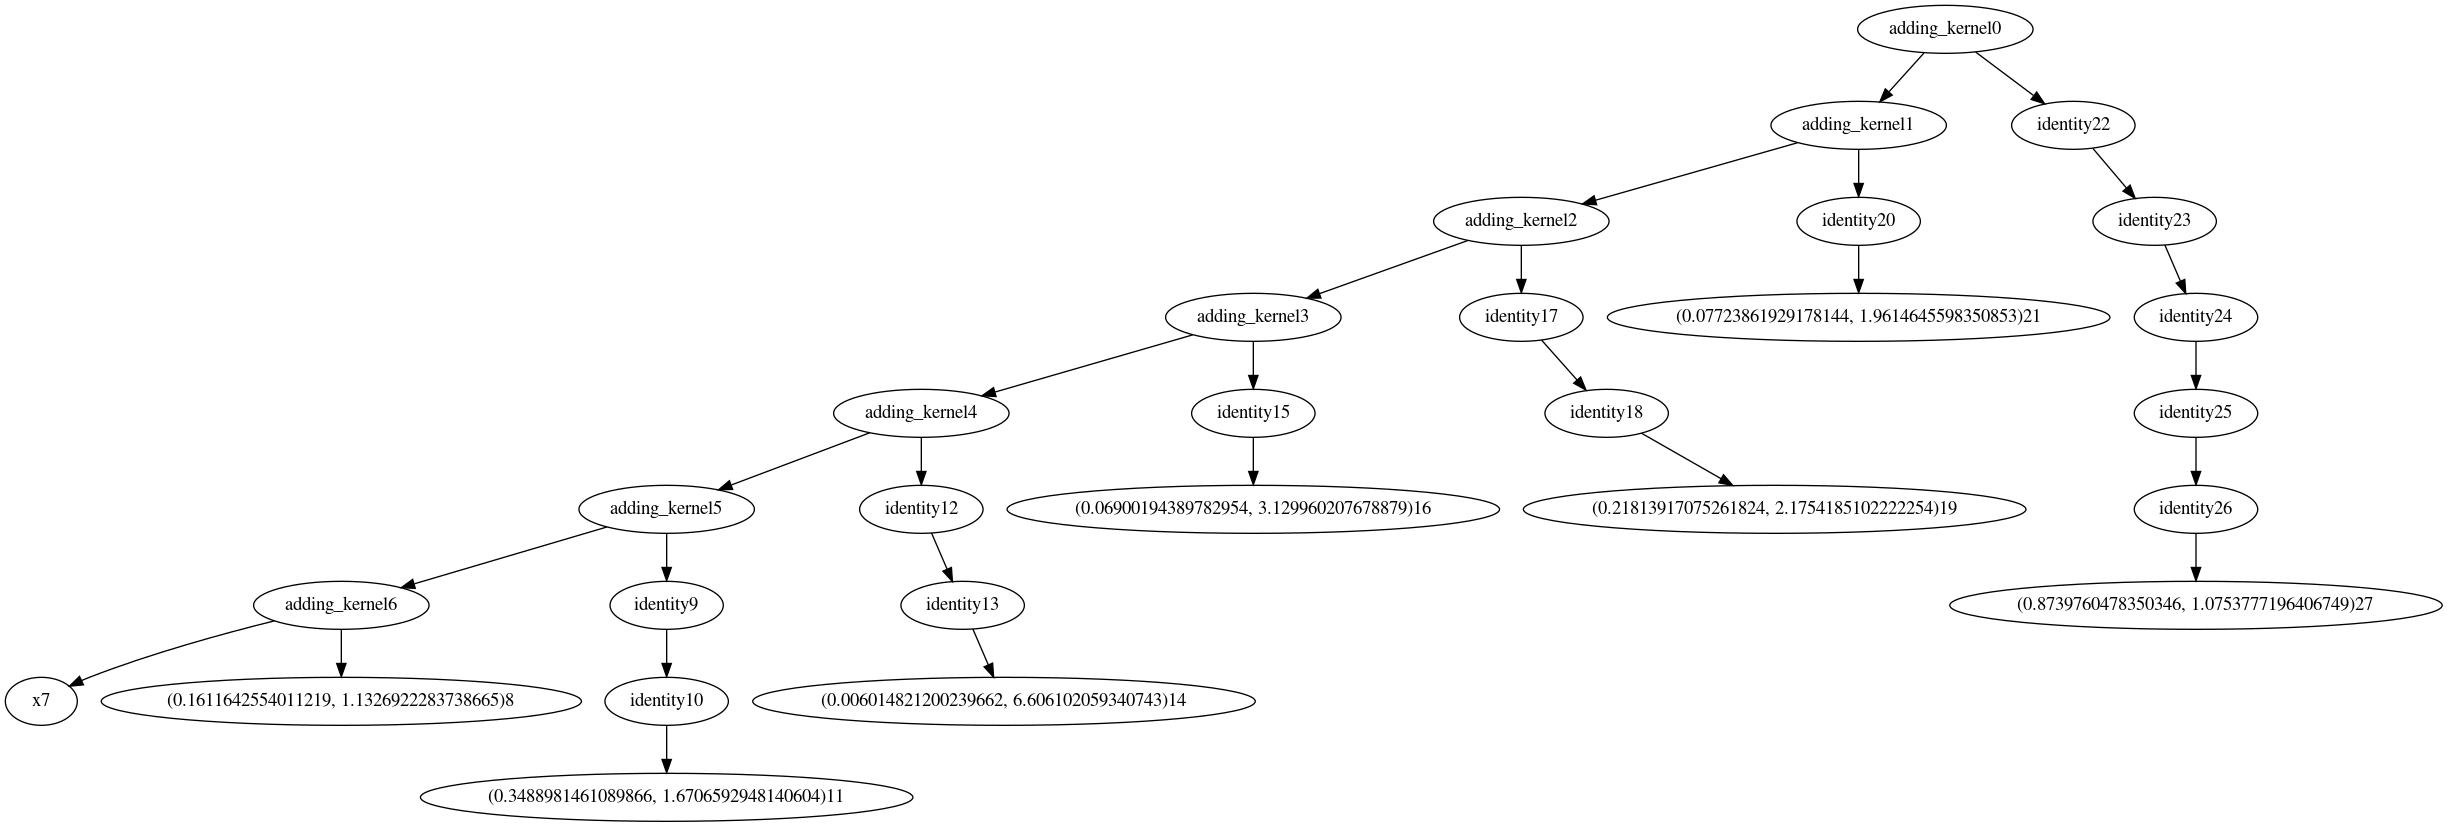

In [9]:
nodes, edges, labels = gp.graph(hof[0])

print(nodes)
print(edges)
print(labels)
sommets = []
arcs = [(str(labels[i])+str(i),str(labels[j])+str(j)) for i,j in edges]
for i,j in arcs:
    if not i in sommets:
        sommets.append(i)
    if not j in sommets:
        sommets.append(j)

G = nx.MultiDiGraph()
G.add_nodes_from(sommets )
G.add_edges_from(arcs)

#for i in nodes:
#    n = G.get_node(i)
#    n.attr["label"] = labels[i]
#

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

import networkx as nx
to_pdot = nx.drawing.nx_pydot.to_pydot
pdot = to_pdot(G)
view_pydot(pdot)

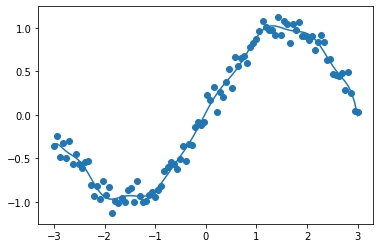

In [10]:
func = toolbox.compile(expr=hof[0])
K = func(X)
w = np.dot(np.linalg.pinv(K.T.dot(K)),K.T.dot(y))
#Calcul des prédictions
ypred = predictions(w.T,K)
plt.scatter(X,y)
#Tracage du modèle : 
plt.plot(X,ypred)
plt.show()

# Résolution d'un problème SAT 

In [112]:
from pysat.formula import CNF
import numpy as np


formula = CNF(from_file='input1.cnf')
clause = formula.clauses
L = []
for c in clause:
    L.append(np.array(c))
L = np.array(L)
print(L)

def transform(clause):
    L = []
    for c in clause:
        L.append(np.array(c))
    L = np.array(L)
    return L



def nb_sat(valuation):
    n = 0
    valuation = np.array(valuation)
    for clause in L:
        if(len(clause)!=0):
            a = valuation[clause]
            for c,cl in zip(a,clause):
                if(c == 1 and cl>0):
                    n = n + 1
                    break
                if(c == 0 and cl<0):
                    n = n + 1
                    break
    return n,

def count_clauses():
    n = 0
    for clause in L:
        if(len(clause)!=0):
            n = n + 1
    return n


nb_sat(np.array((formula.nv+1)*[1]))
print(count_clauses())

[array([ 40, -50,  57]) array([ 45,   7, -39]) array([ 24, -42,  26])
 array([25, 29, 56]) array([-16, -28,  35]) array([40,  9, 64])
 array([54, 67, 43]) array([-14, -33, -42]) array([48,  1, 70])
 array([-36,  27,  56]) array([ -8, -53, -33]) array([-32, -52, -47])
 array([ -1,  -7, -14]) array([  9, -18,  65]) array([ 31,  -6, -27])
 array([-35,   8,  17]) array([ 48,  36, -67]) array([ 1, 36, 66])
 array([-3, 11, 54]) array([ 68, -44,  29]) array([-58,  15, -36])
 array([ 14, -56,  75]) array([-65,   1, -71]) array([17, 10, 70])
 array([  1, -68, -46]) array([  3, -62, -35]) array([ 16, -49,  74])
 array([-11, -49,  31]) array([  8,   4, -39]) array([-20,  13,  54])
 array([64, 34, 12]) array([ 22, -52,  54]) array([55, -8, -1])
 array([39,  7, 67]) array([-64,  29, -16]) array([68,  8, -6])
 array([ -9, -53,  18]) array([ 14, -53,  23]) array([-2, 26, 28])
 array([ 71, -16,  66]) array([-58, -50, -17]) array([-29, -62,  25])
 array([61, 62, -1]) array([-29,  -2, -14]) array([ 18, 

In [113]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, formula.nv+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", nb_sat)


#Proposez un mode d'initialisation, de mutation et de sélection de votre choix en regardant sur le site
#Documentation ici : https://deap.readthedocs.io/en/master/api/tools.html


pop = toolbox.population(n=100)
#Initialiser l'objet stats en lui précisant une fonction lui permettant de savoir pour chaque individu sur quoi
#il est sensé calculer ces stats.
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
#On ajoute des statistiques que l'on veut avoir 
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#Proposez un prototypage rapide et le tester : 

gen	nevals	avg   	std    	min	max
0  	100   	285.58	5.80203	266	300
1  	62    	291.65	4.00344	278	302
2  	77    	295.07	3.761  	286	302
3  	67    	298.83	3.0168 	291	304
4  	59    	299.66	3.38   	288	305
5  	62    	300.88	3.42719	290	307
6  	60    	303.04	2.58813	293	309
7  	74    	304.23	3.47233	295	310
8  	55    	306.26	2.95845	294	310
9  	67    	307.31	3.05187	293	310
10 	66    	308.53	1.9822 	301	311
11 	69    	308.98	2.28026	299	312
12 	68    	309.03	2.68498	299	312
13 	59    	310.09	2.40871	299	313
14 	84    	310.21	3.06038	298	315
15 	65    	310.72	3.3707 	297	315
16 	59    	311.78	3.25447	297	317
17 	56    	313.09	3.57518	297	317
18 	62    	314.21	3.46207	301	318
19 	71    	315.04	3.4552 	303	318
20 	74    	315.38	3.43447	302	318
21 	71    	315.39	3.47533	301	318
22 	66    	315.91	3.55554	305	318
23 	64    	316.11	3.58021	303	318
24 	68    	316.48	3.41901	302	318
25 	64    	315.78	3.68397	305	318
26 	69    	316.26	3.36339	305	318
27 	64    	315.84	3.80978	301	318
28 	59    	316

243	68    	318.2 	3.67151	302	320
244	65    	318.02	3.72553	306	320
245	72    	318.21	3.55329	303	320
246	72    	317.54	4.31143	302	320
247	56    	317.8 	4.10853	300	320
248	78    	317.64	4.22734	301	320
249	69    	318.11	3.82856	304	320
250	55    	318.44	3.31759	305	320
251	75    	318.56	2.85419	305	320
252	60    	318.47	3.09016	307	320
253	74    	318.01	3.97113	303	320
254	61    	318.1 	4.30232	296	320
255	71    	318.32	3.03934	307	320
256	59    	318.42	3.58101	303	320
257	60    	318.31	3.42256	305	320


KeyboardInterrupt: 